# Digit Classifier

In this playbook, you can generate and train a model that can classify between 10 different classes. These classes are the digits. If you want you can classify between any two class of digits or other multi-class classificaiton.

## Import Libraries

In [26]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from torchmetrics import ConfusionMatrix

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

from torch.autograd import Variable

from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.utils import make_grid

from torchvision import models
from torchsummary import summary

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

## Explore and Import the Data

Import dataframes seperatley, then merge and shuffle them

In [5]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively
_train = pd.read_csv('./train.csv')
_test = pd.read_csv('./test_labeled.csv', sep=';')

In [6]:
def extract_DF(df, label):
    temp = df.loc[df['label'] < label+1]
    return temp.loc[temp['label'] > label-1]

In [7]:
# test datasets

class1 = 6
class2 = 8
#class3 = 9
a1 = extract_DF(_train, class1)
a2 = extract_DF(_train, class2)
#a3 = extract_DF(_train, class3)

train_df = pd.concat([a1, a2])#, a3])
train_df = train_df.sample(frac=1).reset_index(drop=True)

# train datasets
e1 = extract_DF(_test, class1)
e2 = extract_DF(_test, class2)
#e3 = extract_DF(_test, class3)

test_df = pd.concat([e1, e2])#, e3])
test_df = test_df.sample(frac=1).reset_index(drop=True)

Here print the first 10 rows of these datasets to verify that they are corectly generated

In [8]:
print("Train:", train_df.iloc[:10,0])
print("Test:", test_df.iloc[:10,0])

Train: 0    8
1    6
2    6
3    8
4    8
5    6
6    8
7    8
8    8
9    8
Name: label, dtype: int64
Test: 0    8
1    8
2    8
3    6
4    6
5    6
6    6
7    6
8    6
9    8
Name: label, dtype: int64


In [9]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print("Number of training samples:",n_train)
print('Number of training pixels: ', n_pixels)
print('Number of classes: ', n_class)

Number of training samples: 8200
Number of training pixels:  784
Number of classes:  2


In [10]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively

n_test = len(test_df)
n_pixels = len(test_df.columns) - 1
n_class = len(set(test_df['label']))

print("Number of training samples:",n_test)
print('Number of training pixels: ', n_pixels)
print('Number of classes: ', n_class)

Number of training samples: 5368
Number of training pixels:  784
Number of classes:  2


## Display Some Images

In [11]:
def dispImage(df, im):
    grid = make_grid(torch.Tensor((df.iloc[im, 1:].to_numpy()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=7)
    plt.rcParams['figure.figsize'] = (32, 150)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.axis('off')

6, 8, 6, 8, 8, 6, 8, 6, 8, 8, 6, 8, 6, 8


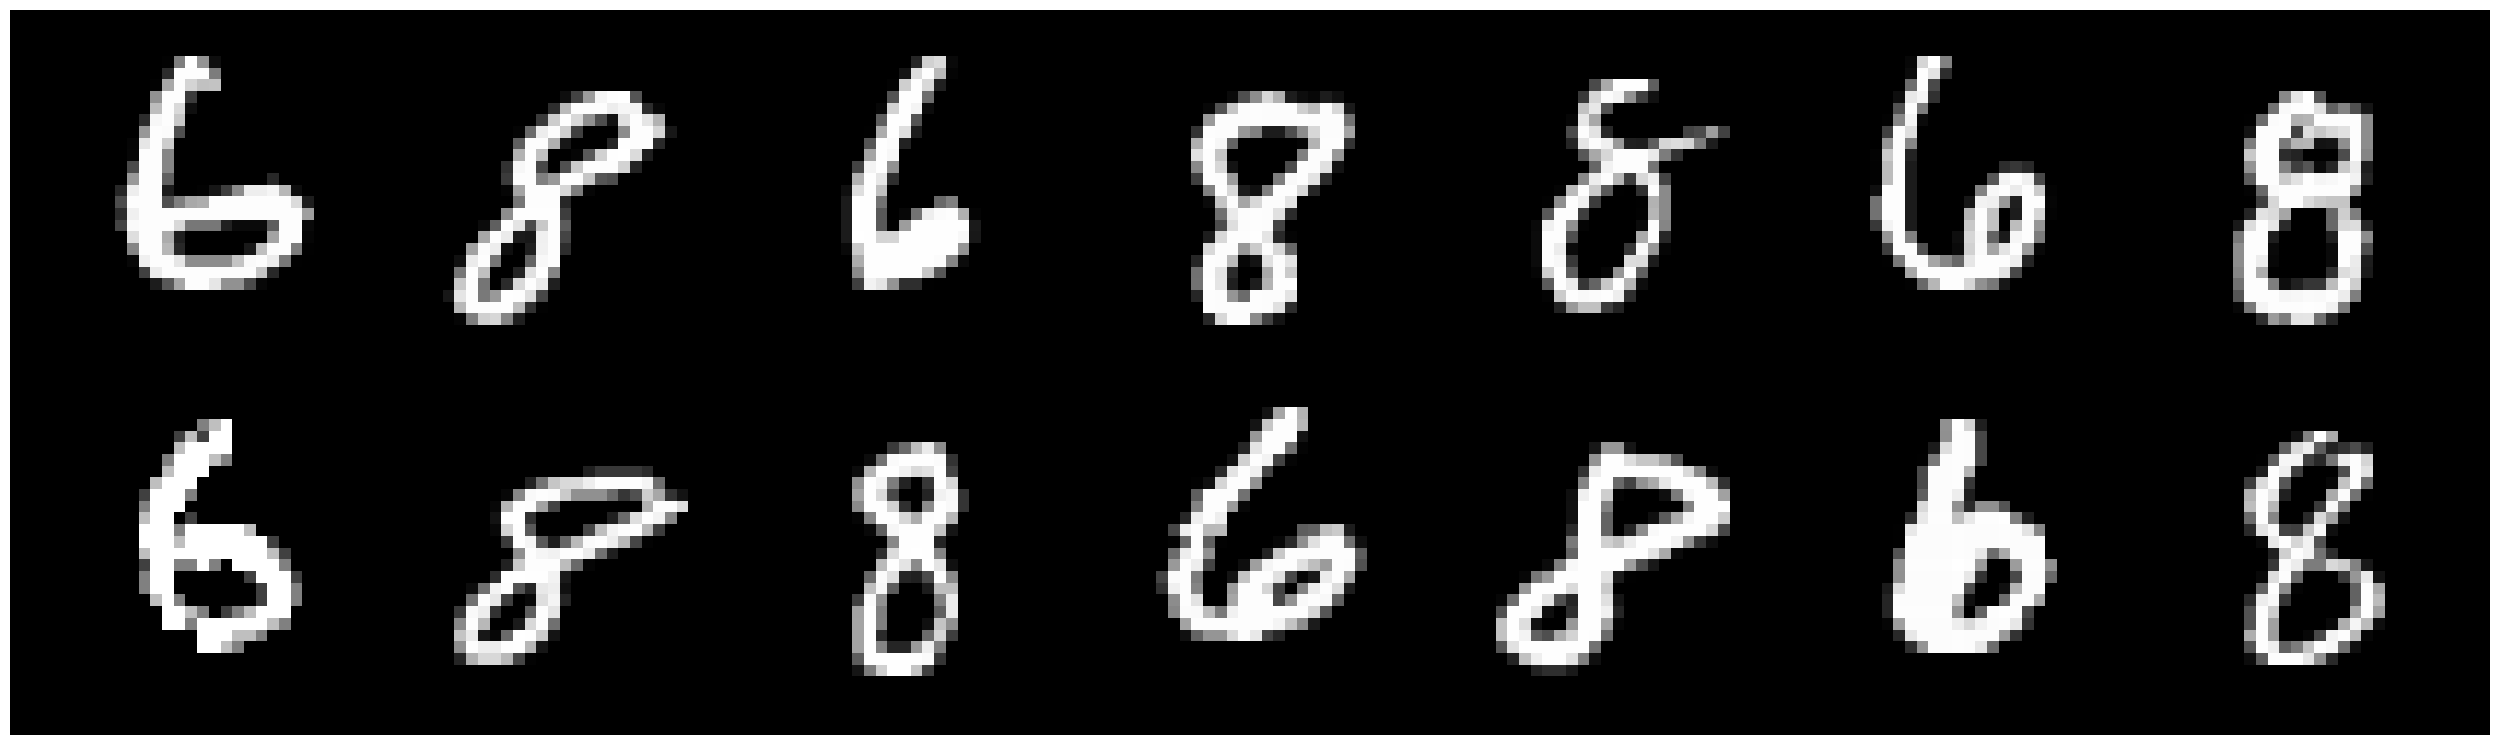

In [12]:
random_sel = np.random.randint(n_train, size=14)
ten = range(10)

dispImage(train_df, random_sel)
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

## Distribution of the Classes among Datasets

Shape of the train_df is:  (8200, 785)
Shape of the test_df is:  (5368, 785)


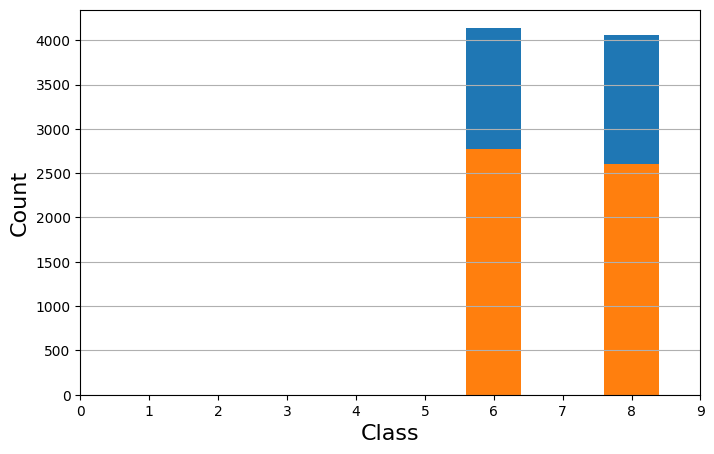

In [13]:
def showHistogram(df):
    plt.rcParams['figure.figsize'] = (8, 5)
    plt.bar(df['label'].value_counts().index, df['label'].value_counts())
    plt.xticks(np.arange(10))
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.grid('on', axis='y')

showHistogram(train_df) # Blue si train
showHistogram(test_df) # Orange is test
print("Shape of the train_df is: ", train_df.shape)
print("Shape of the test_df is: ", test_df.shape)

## Dataloader Class Definiton

Shape of the train_df is:  (8200, 785)
Shape of the test_df is:  (5368, 785)
Shape of the train_df is:  (8200, 785)
Shape of the test_df is:  (5368, 785)
Train: 0    1
1    0
2    0
3    1
4    1
5    0
6    1
7    1
8    1
9    1
Name: label, dtype: int64
Test: 0    1
1    1
2    1
3    0
4    0
5    0
6    0
7    0
8    0
9    1
Name: label, dtype: int64


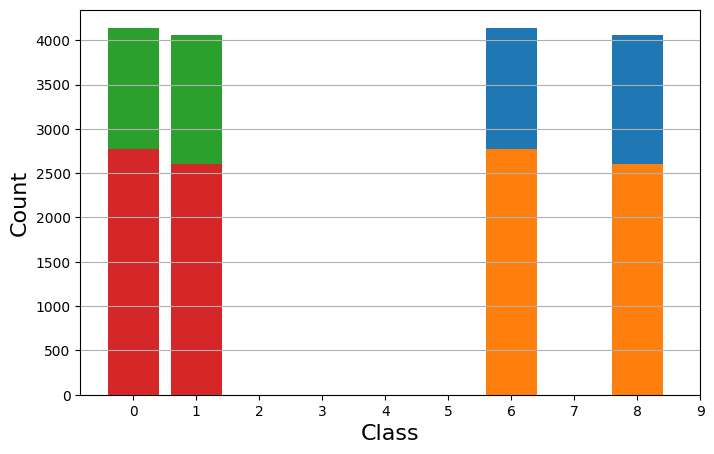

In [14]:
showHistogram(train_df) # Blue si train
showHistogram(test_df) # Orange is test
print("Shape of the train_df is: ", train_df.shape)
print("Shape of the test_df is: ", test_df.shape)

for i in range(len(train_df[:])):
    if train_df.iloc[i,0] == 6:
        train_df.iloc[i,0] = 0
        
    if train_df.iloc[i,0] == 8:
        train_df.iloc[i,0] = 1
    
for i in range(len(test_df[:])):
    if test_df.iloc[i,0] == 6:
        test_df.iloc[i,0] = 0
        
    if test_df.iloc[i,0] == 8:
        test_df.iloc[i,0] = 1

showHistogram(train_df) # Blue si train
showHistogram(test_df) # Orange is test
print("Shape of the train_df is: ", train_df.shape)
print("Shape of the test_df is: ", test_df.shape)

print("Train:", train_df.iloc[:10,0])
print("Test:", test_df.iloc[:10,0])

In [15]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    
    
    def __init__(self, 
                 df_, #file_path, 
                 sep=',', 
                 isTest=False,
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = df_ #pd.read_csv(file_path, sep=sep)
        self.df = df_
        
        if isTest:
            # test data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def get_labels(self):
        return df.iloc[:,0]

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

## Random Rotation

In [16]:
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """
                
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

## Random Shift

In [17]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
    

## Define the Datasets and Dataloaders

In [18]:
batch_size = 64

train_dataset = MNIST_data(train_df, transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)




test_dataset = MNIST_data(test_df, sep=';', isTest=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

train_x_dataset = MNIST_data(train_df, isTest=True)
train_x_loader = torch.utils.data.DataLoader(dataset=train_x_dataset, batch_size=batch_size, shuffle=False)


test_y_dataset = MNIST_data(test_df, sep=';')
test_y_loader = torch.utils.data.DataLoader(dataset=test_y_dataset, batch_size=batch_size, shuffle=True)


1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1
1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1


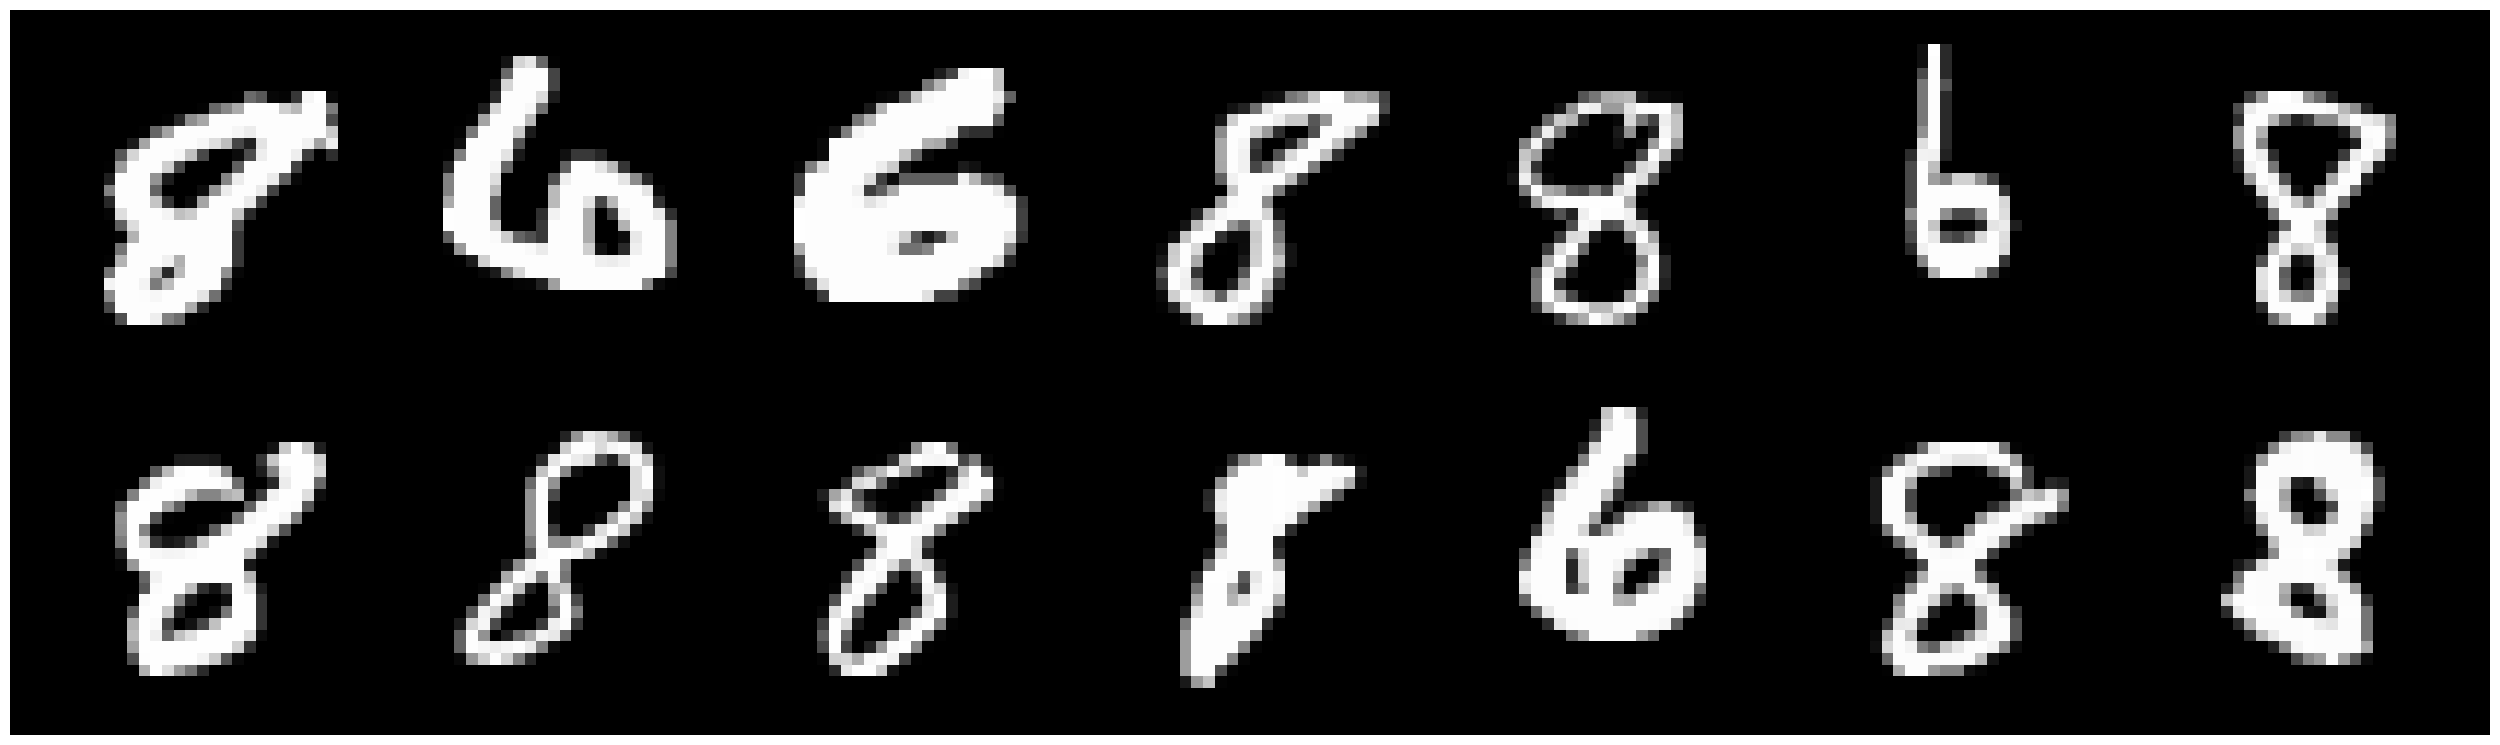

In [19]:
dispImage(train_df, np.arange(14))
    
print(*list(train_df.iloc[:14, 0].values), sep = ', ')
print(*list(train_dataset.df.iloc[:14,0].values), sep = ', ')

## Demonstration of Random Rotation & Shift

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_24378/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_24378/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)


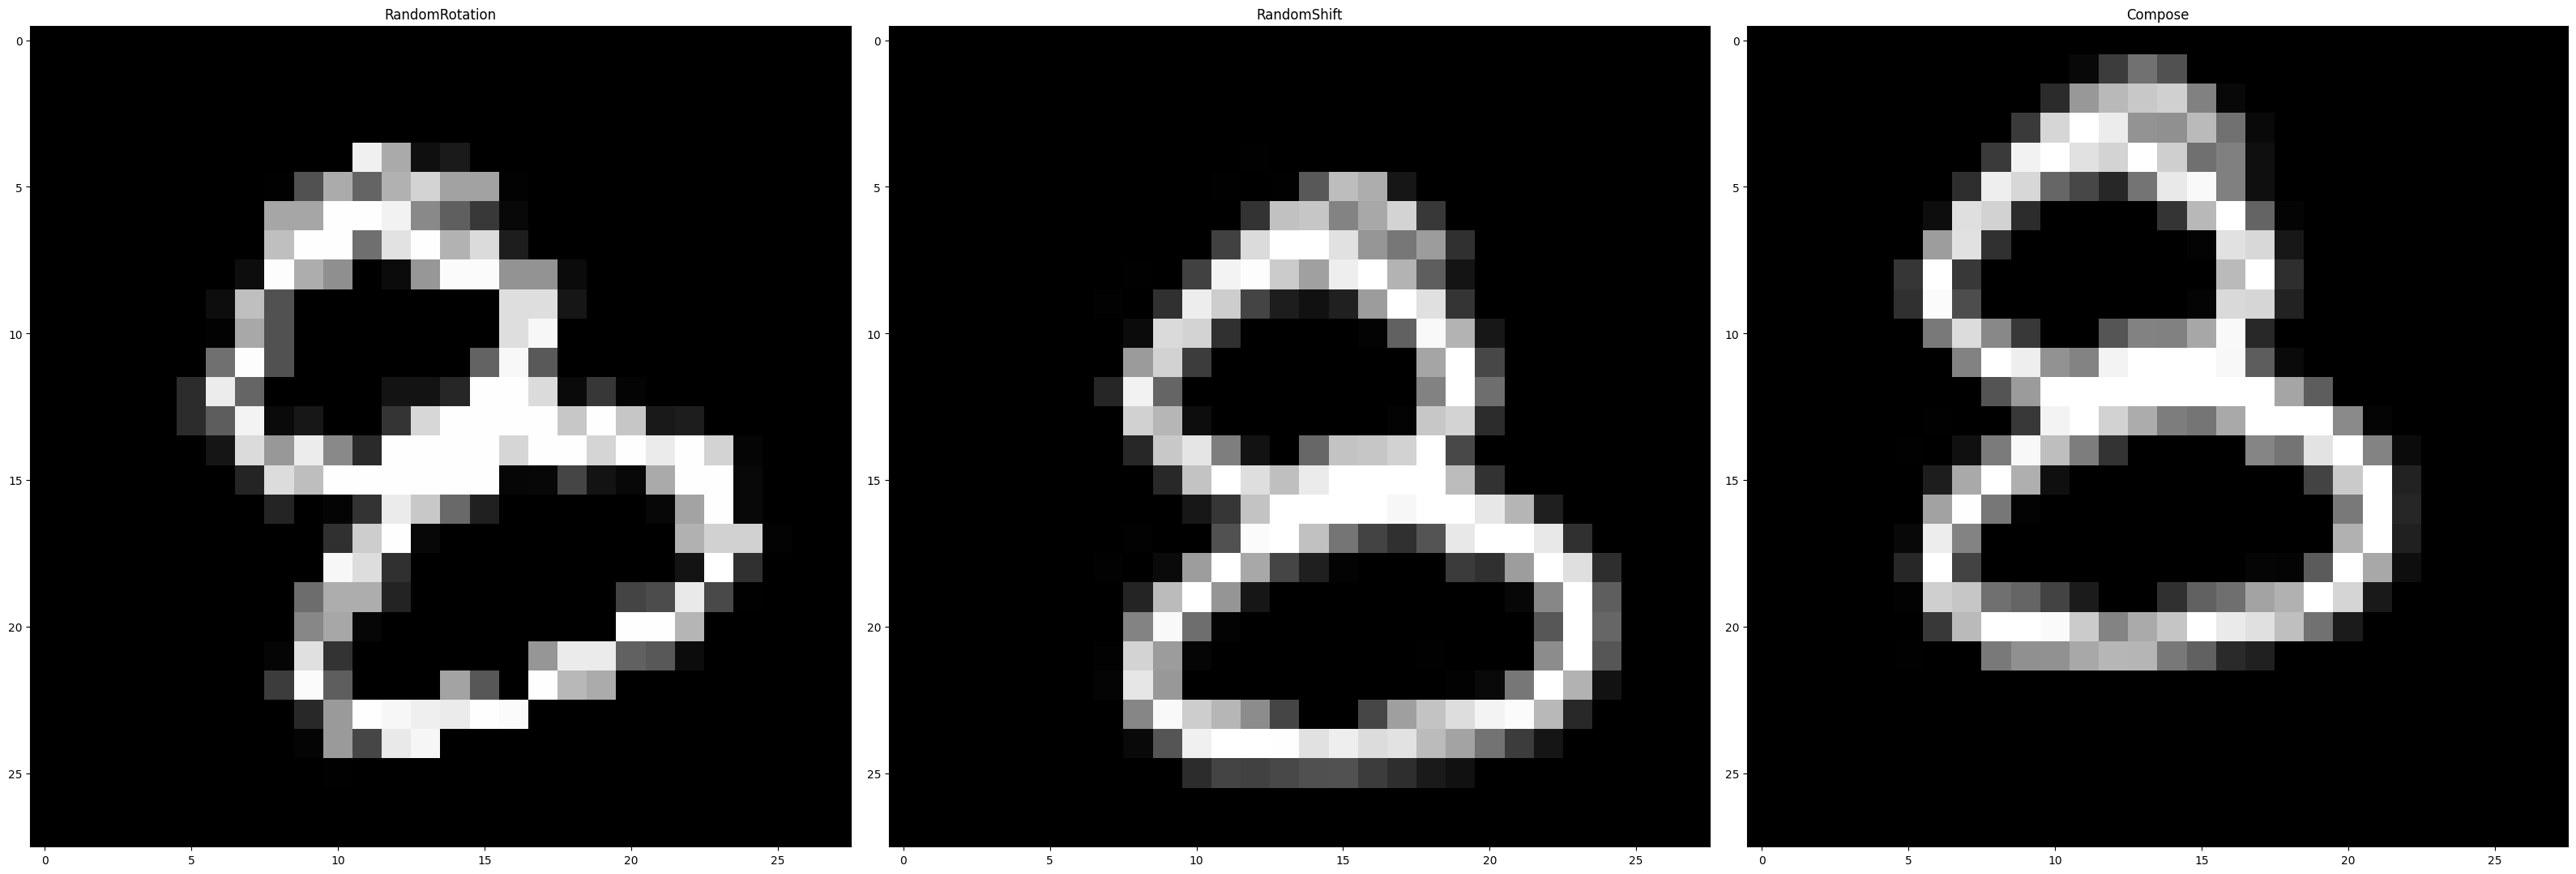

In [20]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

## Define the Neural Network

In [21]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.hidden = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p = 0.5),
            # This is the last layer i.e., output layer of the network
            #nn.Linear(512, 10),
            nn.Linear(512, 2),
        )
          
        for m in self.hidden.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.hidden(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        print(x.shape)
        
        return x     

## Initialize the Model

In [28]:
model = Net()
print(model)
summary(model, (1, 28, 28))

optimizer = optim.Adam(model.parameters(), lr=0.003) #0.003

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

Net(
  (hidden): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(


/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_24378/380934005.py:52: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


## Training Algorithm

In [25]:
loss_values = []
def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data), Variable(target)
        
        #If its available move to gpu from cup 
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        
        
        #Clears the previously calculated gradient 
        optimizer.zero_grad()
        
        #Gives an output
        output = model(data)
        
        #Calculates the loss
        loss = criterion(output, target)
        
        
        #To print the loss graph
        val = F.cross_entropy(output, target, size_average=False).data
        loss_values.append(val)
        
        
        #Calculates the gradient
        loss.backward()
        
        #Does the update
        optimizer.step()
        
        
        
        if (batch_idx + 1)% 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
    
    
    exp_lr_scheduler.step()

## Evaluation of Training

In [26]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

## Train the Model

In [27]:
n_epochs = 1

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_23179/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_23179/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/Users/ilerisoy/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
Train Epoch: 0 [640/8200 (8%)]	Loss: 0.289033
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
Train Epoch: 0 [1280/8200 (16%)]	Loss: 0.126455
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
Train Epoch: 0 [1920/8200 (23%)]	Loss: 0.133760
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
Train Epoch: 0 [2560/8200 (31%)]	Loss: 0.039443
torch.Size

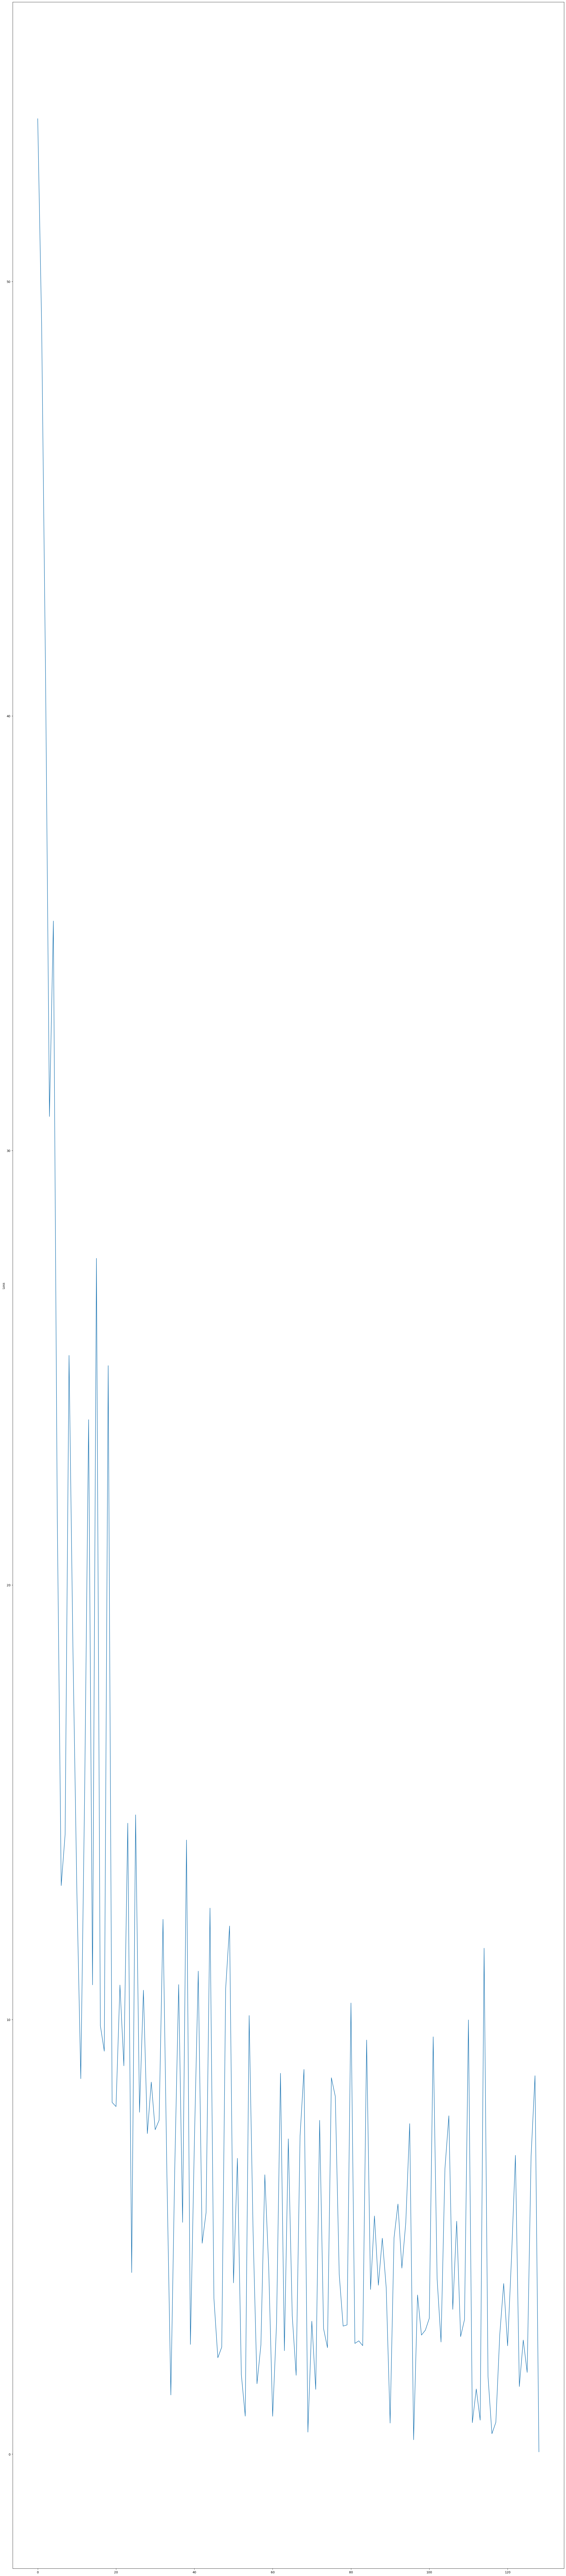

[tensor(53.7445), tensor(49.0141), tensor(40.9500), tensor(30.7825), tensor(35.2808)] [tensor(2.6237), tensor(1.8796), tensor(6.8580), tensor(8.7075), tensor(0.0512)]
129


In [28]:
plt.plot(loss_values)
plt.ylabel('Loss')
plt.show()

print(loss_values[0:5], loss_values[len(loss_values)-5:])
print(len(loss_values))

## Prediction Algorithm

In [29]:
train_prob = []
test_prob = []
def prediciton(data_loader, df_type):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        
        data = Variable(data)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
            
        output = model(data)
        
        
        
        ####        
        batch_prob = F.softmax(output, dim=1)
        if df_type == "train":
            for i in range(len(batch_prob)):
                train_prob.append(batch_prob[i])
        elif df_type == "test":
            for i in range(len(batch_prob)):
                test_prob.append(batch_prob[i])
        else:
            print("Wrong df type is given...")
            return 0
        ####
        
        
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [30]:
train_pred = prediciton(train_x_loader, "train")

torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])


In [31]:
test_pred = prediciton(test_loader, "test")

torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])


## Function to Get the Confidence Values

In [32]:
def getProbs(rawProbs):
    temp = []
    
    for i in range(len(rawProbs)):
        temp.append(rawProbs[i].detach().numpy())

    return temp

train_probs = getProbs(train_prob)
test_probs = getProbs(test_prob)

In [33]:
class1 = 0
class2 = 1
item = 0

print(train_probs[item])
print(test_probs[item])
print(train_probs[item][class1])
print(test_probs[item][class1])

[9.999994e-01 5.445214e-07]
[0.12797792 0.87202203]
0.9999994
0.12797792


# Training Prediction

In [34]:
train_prediction_df = pd.DataFrame(np.c_[np.arange(1, len(train_dataset)+1)[:,None], train_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# Make a numpay array by predcited labels
train_predictions = train_prediction_df.iloc[:,1].to_numpy()
train_labels = train_df.iloc[:,0].to_numpy()
print(len(train_predictions), train_predictions[:10], train_labels[:10])

8200 [0 1 0 1 1 0 1 0 0 1] [0 1 0 1 1 0 1 0 0 1]


In [35]:
train_predictions = train_prediction_df.iloc[:, 1].to_numpy()

count = 0
train_index = []

for i in range(len(train_predictions)):
    if train_labels[i] == train_predictions[i]:
        continue
    else:
        count +=1
        train_index.append(i)
        print("Label is: ", train_labels[i], "Predcition is: ", train_predictions[i], "index is: ", i)
print(count)

Label is:  1 Predcition is:  0 index is:  50
Label is:  1 Predcition is:  0 index is:  74
Label is:  1 Predcition is:  0 index is:  141
Label is:  1 Predcition is:  0 index is:  173
Label is:  1 Predcition is:  0 index is:  223
Label is:  1 Predcition is:  0 index is:  249
Label is:  1 Predcition is:  0 index is:  264
Label is:  1 Predcition is:  0 index is:  277
Label is:  1 Predcition is:  0 index is:  291
Label is:  1 Predcition is:  0 index is:  297
Label is:  1 Predcition is:  0 index is:  349
Label is:  1 Predcition is:  0 index is:  375
Label is:  1 Predcition is:  0 index is:  556
Label is:  1 Predcition is:  0 index is:  594
Label is:  1 Predcition is:  0 index is:  596
Label is:  1 Predcition is:  0 index is:  670
Label is:  1 Predcition is:  0 index is:  689
Label is:  1 Predcition is:  0 index is:  748
Label is:  1 Predcition is:  0 index is:  796
Label is:  1 Predcition is:  0 index is:  804
Label is:  1 Predcition is:  0 index is:  853
Label is:  0 Predcition is:  1 index

In [36]:
con_train = confusion_matrix(train_dataset.df.iloc[:,0], train_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_train,"\n")


# Class 0 is treated as Negative
tn, fp, fn, tp = con_train.ravel()

prec_test = tp/(tp+fp)
sens = tp/(tp+fn)
spec = tn/(tn+fp)

total = tp+tn+fn+fp
acc = (tp+tn)*100/total
print("Accuracy is: %", acc)

print("\nPrecision is: ", prec_test)

print("Sensitivity is: ", sens)
print("Specificity is: ", spec)


print("\nTP: ", tp, "FP: ", fp)
print("FN: ", fn, "  TN: ", tn)


Confusion Matrix is:

[[4135    2]
 [ 190 3873]] 

Accuracy is: % 97.65853658536585

Precision is:  0.9994838709677419
Sensitivity is:  0.9532365247354172
Specificity is:  0.9995165578921924

TP:  3873 FP:  2
FN:  190   TN:  4135


Image :  0
Confidance values are :  0.78842384 0.21157615
Ground Truth is:  1
Predicted as:  0
Image :  1
Confidance values are :  0.95986867 0.040131364
Ground Truth is:  1
Predicted as:  0
Image :  2
Confidance values are :  0.65567285 0.34432718
Ground Truth is:  1
Predicted as:  0
Image :  3
Confidance values are :  0.55413985 0.4458601
Ground Truth is:  1
Predicted as:  0
Image :  4
Confidance values are :  0.72526354 0.27473643
Ground Truth is:  1
Predicted as:  0
Image :  5
Confidance values are :  0.8537047 0.14629537
Ground Truth is:  1
Predicted as:  0
Image :  6
Confidance values are :  0.5991459 0.4008541
Ground Truth is:  1
Predicted as:  0
Image :  7
Confidance values are :  0.69787115 0.30212882
Ground Truth is:  1
Predicted as:  0
Image :  8
Confidance values are :  0.65799856 0.34200147
Ground Truth is:  1
Predicted as:  0
Image :  9
Confidance values are :  0.68788236 0.31211764
Ground Truth is:  1
Predicted as:  0
Image :  10
Confidance values are :  0.5404282 0.4595

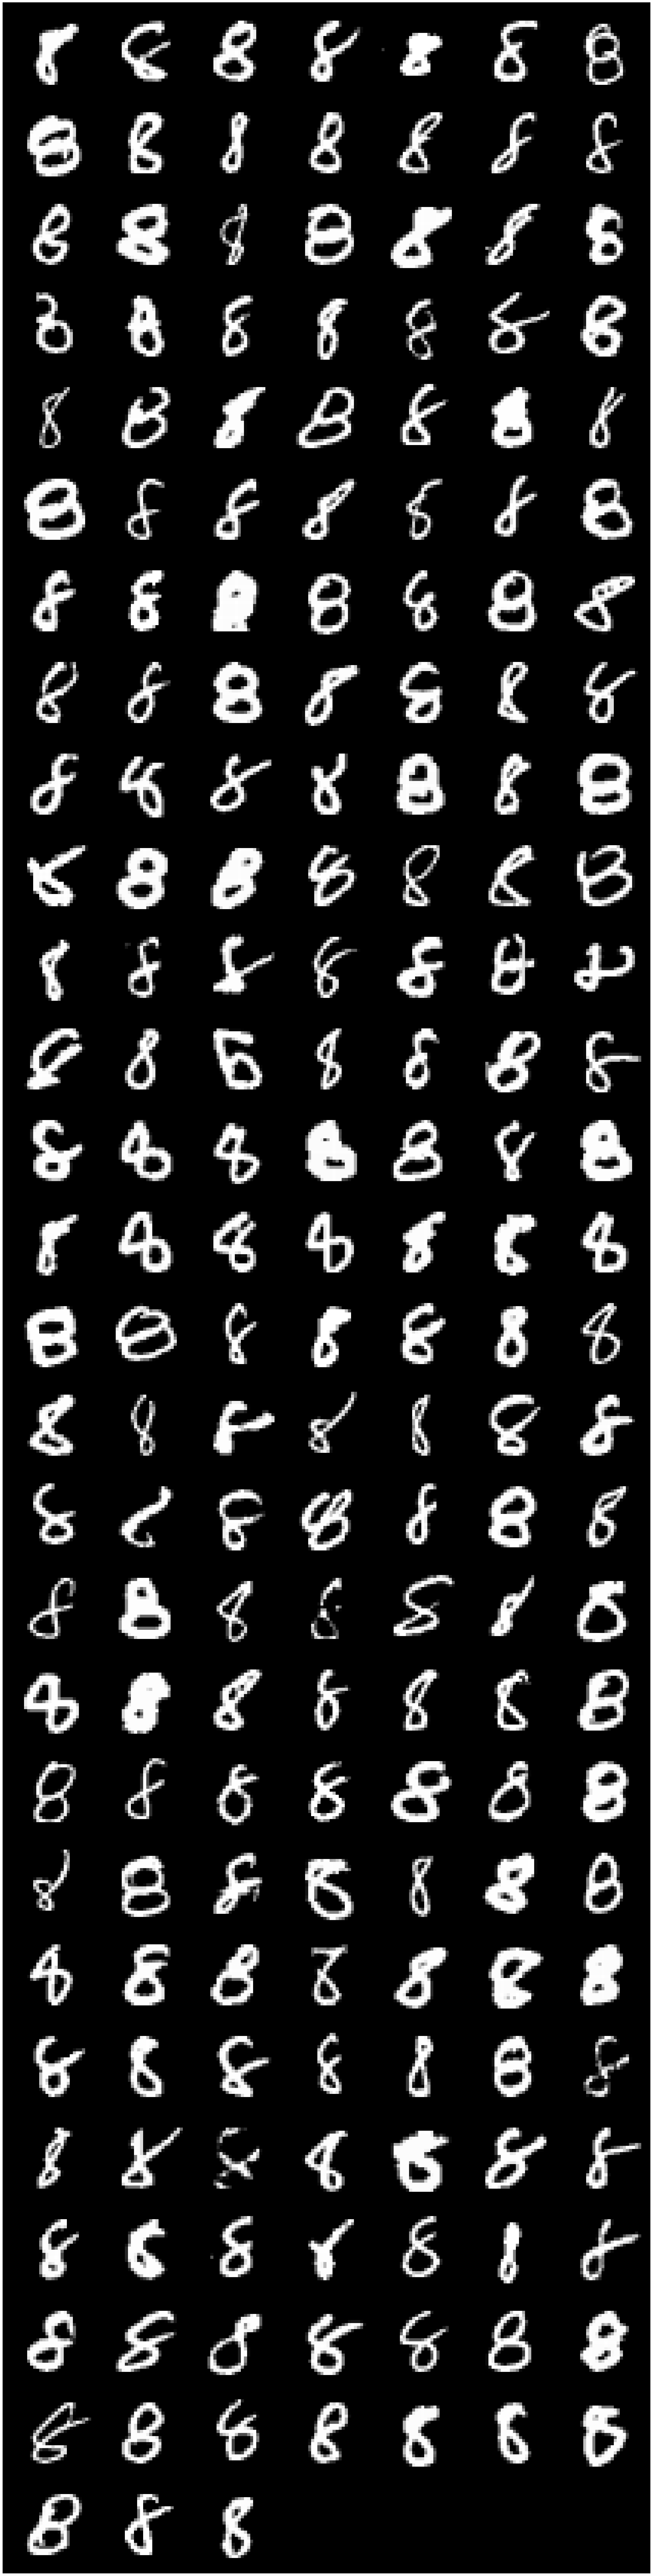

In [37]:
sel = count

for i in range(sel):
    print("Image : ", i)
    print("Confidance values are : ", train_probs[train_index[i]][class1], train_probs[train_index[i]][class2])
    print("Ground Truth is: ", train_df.iloc[train_index[i],0])
    print("Predicted as: ", train_predictions[train_index[i]])

dispImage(train_df, train_index[:sel])

# Test Prediction

In [38]:
test_pred_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [39]:
test_prediction_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# Make a numpay array by predcited labels
test_predictions = test_prediction_df.iloc[:,1].to_numpy()
test_labels = test_y_dataset.df.iloc[:,0].to_numpy()
print(len(test_predictions), test_predictions[:10], test_labels[:10])

5368 [1 0 0 0 0 1 1 0 1 0] [1 0 0 0 1 1 1 0 1 0]


In [40]:
test_predictions = test_prediction_df.iloc[:, 1].to_numpy()

count2 = 0
test_index = []

for i in range(len(test_predictions)):
    if test_labels[i] == test_predictions[i]:
        continue
    else:
        count2 +=1
        test_index.append(i)
        print("Label is: ", test_y_dataset.y.numpy()[i], "Predcition is: ", test_predictions[i], "index is: ", i)
print(count2)

Label is:  1 Predcition is:  0 index is:  4
Label is:  1 Predcition is:  0 index is:  18
Label is:  1 Predcition is:  0 index is:  107
Label is:  1 Predcition is:  0 index is:  123
Label is:  0 Predcition is:  1 index is:  146
Label is:  1 Predcition is:  0 index is:  392
Label is:  1 Predcition is:  0 index is:  523
Label is:  1 Predcition is:  0 index is:  573
Label is:  1 Predcition is:  0 index is:  578
Label is:  1 Predcition is:  0 index is:  619
Label is:  1 Predcition is:  0 index is:  650
Label is:  1 Predcition is:  0 index is:  811
Label is:  1 Predcition is:  0 index is:  871
Label is:  1 Predcition is:  0 index is:  910
Label is:  1 Predcition is:  0 index is:  921
Label is:  1 Predcition is:  0 index is:  967
Label is:  1 Predcition is:  0 index is:  1011
Label is:  1 Predcition is:  0 index is:  1024
Label is:  1 Predcition is:  0 index is:  1085
Label is:  1 Predcition is:  0 index is:  1271
Label is:  1 Predcition is:  0 index is:  1282
Label is:  1 Predcition is:  0 i

In [41]:
test_predictions = test_pred_df.iloc[:, 1].to_numpy()
con_test = confusion_matrix(test_dataset.df.iloc[:,0], test_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_test,"\n")


# Class 0 is treated as Negative
tn, fp, fn, tp = con_test.ravel()

prec_test = tp/(tp+fp)
sens = tp/(tp+fn)
spec = tn/(tn+fp)

total = tp+tn+fn+fp
acc = (tp+tn)*100/total
print("Accuracy is: %", acc)

print("\nPrecision is: ", prec_test)

print("Sensitivity is: ", sens)
print("Specificity is: ", spec)


print("\nTP: ", tp, "FP: ", fp)
print("FN: ", fn, "  TN: ", tn)


Confusion Matrix is:

[[2760    7]
 [  92 2509]] 

Accuracy is: % 98.15573770491804

Precision is:  0.9972178060413355
Sensitivity is:  0.9646289888504421
Specificity is:  0.9974701843151428

TP:  2509 FP:  7
FN:  92   TN:  2760


Image :  0
Confidance values are :  0.9423324 0.057667628
Ground Truth is:  1
Predicted as:  0
Image :  1
Confidance values are :  0.6356273 0.36437267
Ground Truth is:  1
Predicted as:  0
Image :  2
Confidance values are :  0.9780011 0.021998908
Ground Truth is:  1
Predicted as:  0
Image :  3
Confidance values are :  0.68899703 0.31100297
Ground Truth is:  1
Predicted as:  0
Image :  4
Confidance values are :  0.48767263 0.5123274
Ground Truth is:  0
Predicted as:  1
Image :  5
Confidance values are :  0.9304049 0.06959511
Ground Truth is:  1
Predicted as:  0
Image :  6
Confidance values are :  0.87469804 0.12530197
Ground Truth is:  1
Predicted as:  0
Image :  7
Confidance values are :  0.8772614 0.12273853
Ground Truth is:  1
Predicted as:  0
Image :  8
Confidance values are :  0.9004586 0.09954149
Ground Truth is:  1
Predicted as:  0
Image :  9
Confidance values are :  0.8717502 0.12824985
Ground Truth is:  1
Predicted as:  0
Image :  10
Confidance values are :  0.68949926 0.310500

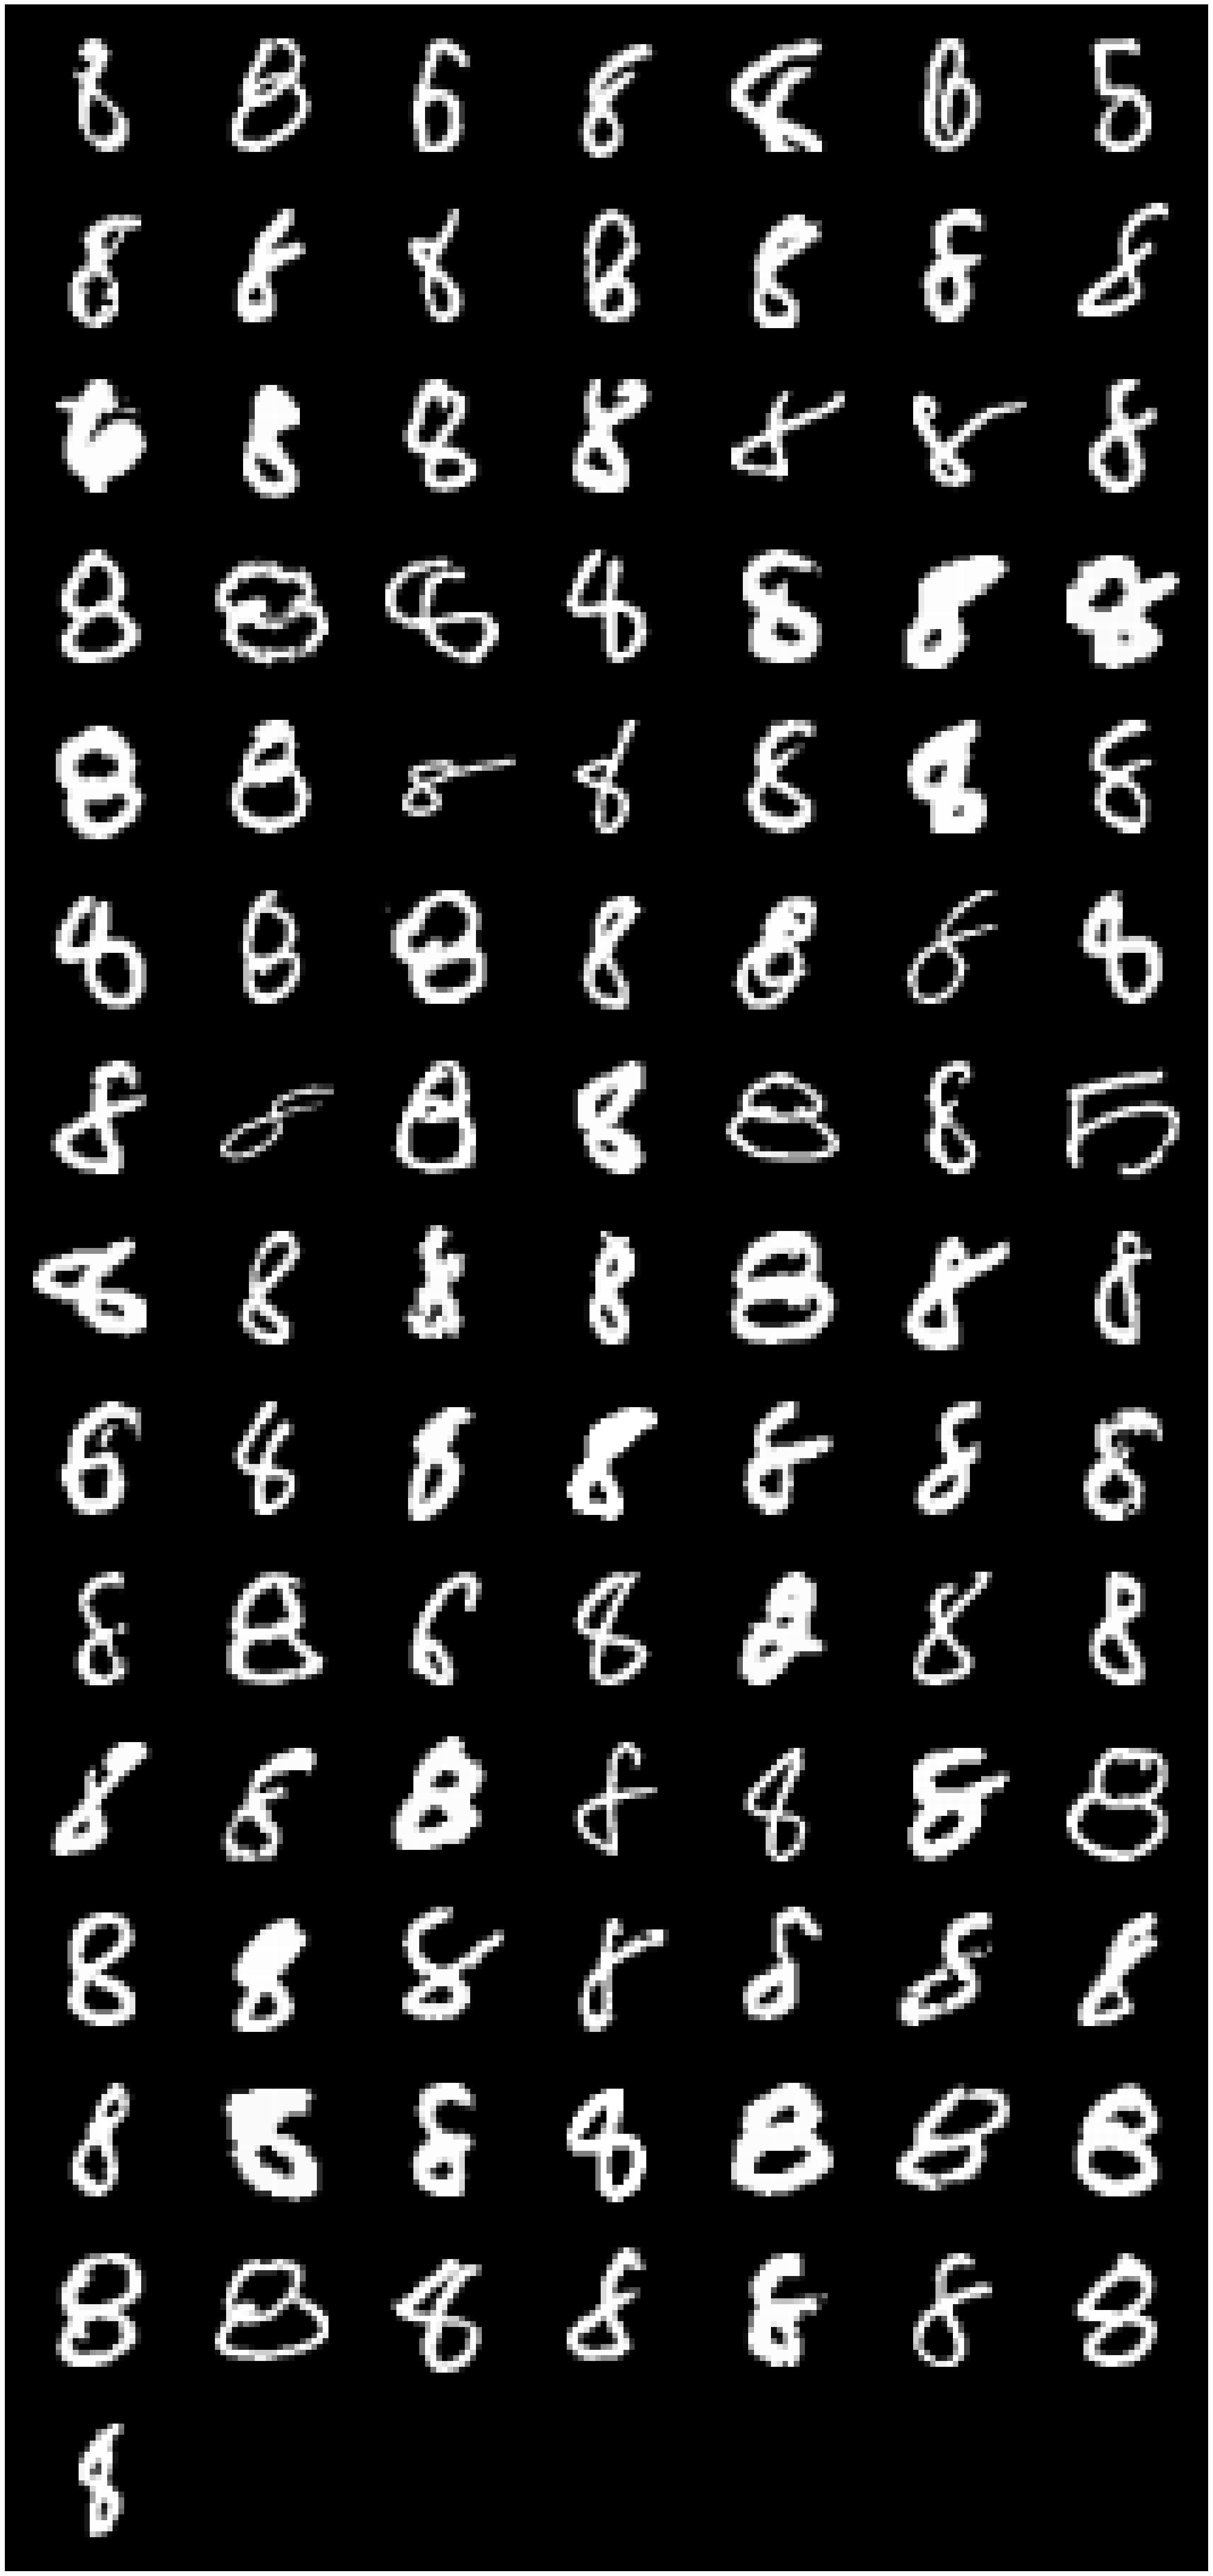

In [42]:
sel2 = count2

for i in range(sel2):
    print("Image : ", i)
    print("Confidance values are : ", test_probs[test_index[i]][class1], test_probs[test_index[i]][class2])
    print("Ground Truth is: ", test_df.iloc[test_index[i],0])
    print("Predicted as: ", test_predictions[test_index[i]])

dispImage(test_df, test_index[:sel2])

In [43]:
npv = tn/(tn+fn)
print(npv)

0.967741935483871
